## Классификации изображений ResNet


In [1]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from torchvision import transforms
import random
from tqdm.notebook import trange, tqdm
from tqdm.auto import tqdm,trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18

In [2]:
def set_random_seed(seed): # функция для фисакции сида
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_random_seed(17)

### Подготовка данных

In [4]:
!wget -O dataset.zip https://www.dropbox.com/s/t60xtgfy2uoln3f/dataset.zip
!unzip -qq dataset.zip -d dataset  

--2022-07-01 14:57:56--  https://www.dropbox.com/s/t60xtgfy2uoln3f/dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t60xtgfy2uoln3f/dataset.zip [following]
--2022-07-01 14:57:56--  https://www.dropbox.com/s/raw/t60xtgfy2uoln3f/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc89b56f4a4ee63abc5796fb7ea1.dl.dropboxusercontent.com/cd/0/inline/BoTERaK7PcBYWxseHrTxgmYgbpK2tFT6cCokPs_9TOjvdRt7kr7u5yntfnCbirJZxnkCLbYXnUSJ3RcLqwepxZkH1GwM0oNgJChTZ7y0EuxJfDziuo0ym5VZKGYDyXC5EE1gjBei-g2ynqKvkg9cYt0UIw499886AzRDR6RktM5lYw/file# [following]
--2022-07-01 14:57:57--  https://uc89b56f4a4ee63abc5796fb7ea1.dl.dropboxusercontent.com/cd/0/inline/BoTERaK7PcBYWxseHrTxgmYgbpK2tFT6cCokPs_9TOjvdRt7kr7u5yntfnCbirJZxnkC

In [5]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder("/content/dataset/dataset/dataset/train", transform=train_transform)

mean_p = 0
std_p = 0

for image, label in train_dataset:
    mean_p += image.mean(dim=(1,2)) / len(train_dataset) # cчитаю средние значения по батчам 
    std_p += image.std(dim=(1,2)) / len(train_dataset) # cчитаю стандартные отклонения по батчам 
        
print(mean_p)
print(std_p)

tensor([0.4802, 0.4481, 0.3975])
tensor([0.2302, 0.2265, 0.2262])


In [6]:
train_transform = transforms.Compose(
    [
    transforms.ColorJitter(hue=0.02, saturation=0.03), # меняю насыщенность и оттенок изображения
    transforms.RandomHorizontalFlip(), # горизонтально передвигаю изображение
    transforms.RandomRotation(5, resample=Image.BILINEAR), # поворачиваю изображение
    transforms.ToTensor(), 
    transforms.Normalize(mean_p, # нормализую по полученным ранее данным средних и стандартных отклонений
                         std_p)
    ]
)
val_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean_p,  # нормализую по полученным ранее данным средних и стандартных отклонений
                         std_p)
    ]
)

train_dataset = torchvision.datasets.ImageFolder("/content/dataset/dataset/dataset/train", transform=train_transform) # трансформирую изображения с определенным для трейна transforma
val_dataset = torchvision.datasets.ImageFolder("/content/dataset/dataset/dataset/val", transform=val_transform) # трансформирую изображения с определенным для теста transforma

train_dataloader = torch.utils.data.DataLoader( # разделяю данные для трейна по батчам 
    train_dataset, 
    batch_size=48,
    shuffle=True, 
    num_workers=1
)

val_dataloader = torch.utils.data.DataLoader( # разделяю данные для теста по батчам 
    val_dataset,
    batch_size=1,
    shuffle=False, 
    num_workers=1
)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1293: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


In [7]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


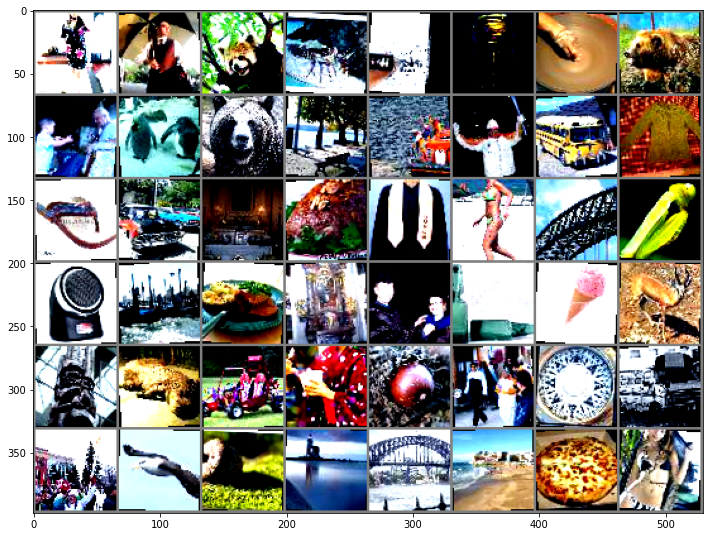

In [8]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)
# запринтили один батч даталоадера

### Вспомогательные функции реализация модели

In [9]:
def plot_history(train_history, val_history, title="loss"): # функция для вывода графиков
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [10]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cpu"):
    train_dataset = torchvision.datasets.ImageFolder("/content/dataset/dataset/dataset/train", transform=train_transform) # провожу аугментацию по эпохам

    train_dataloader = torch.utils.data.DataLoader( 
        train_dataset, 
        batch_size=48,
        shuffle=True,
        num_workers=1
    )

    model.to(device).train() # начинаю обучение модели
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    for imgs, labels in tqdm(train_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        y_pred = model(imgs) # делаю предсказания
        loss = criterion(y_pred, labels) # получаю данные по критерию
        loss.backward() # считаю производные
        optimizer.step() # спускаюсь по критерию
        optimizer.zero_grad() # обнуляю градиент
        
        total_loss += loss.item() # cчитаю лоссы о батчам
        total_predictions = np.append(total_predictions, y_pred.argmax(1).cpu().detach().numpy()) # сохраняю все предсказания 
        total_labels = np.append(total_labels, labels.cpu().detach().numpy()) # сохраняю правильные классы
        num_batches += 1 
        all_losses.append(loss.detach().item()) # сохраняю лоссы
 
    metrics = {"loss": total_loss / num_batches} # сохраняю лосс в эпохе
    metrics.update({"accuracy": accuracy_score(total_predictions, total_labels)}) # сохраняю точность модели по всем батчам
    
    return metrics, all_losses
    

def predict(model, val_dataloder, criterion, device="cpu"):
    model.to(device).eval() # модель не обучается
    losses = np.array([])
    predicted_classes = np.array([])
    true_classes = np.array([])

    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            predictions = model(imgs)
            loss = criterion(predictions, labels)
                        
            losses = np.append(losses,loss.cpu().detach().numpy()) # сохраняю лоссы по тестовой выборке 
            predicted_classes = np.append(predicted_classes ,predictions.argmax(1).cpu().detach().numpy()) # сохраняю предсказания по тестовой выборке
            true_classes = np.append(true_classes, labels.cpu().detach().numpy()) # сохраняю настоящие классы изображений

    return losses, predicted_classes, true_classes 


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cpu", n_epochs=10, scheduler=None):
    model.to(device) 
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(n_epochs):
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_one_epoch(model, train_dataloader, criterion, optimizer) # обучаю одну эпоху
        
        scheduler.step(one_epoch_train_losses[-1]) # делаю шаг шедаллер по лоссу
        all_train_losses.extend(one_epoch_train_losses) # сохраняю лосс эохи
        epoch_train_losses.append(train_metrics["loss"]) # разделяю данные для трейна по батчам для эпох

        with torch.no_grad():
            losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device="cuda:0") # делаю предсказания по тестовой выборке

        clear_output()    
        epoch_eval_losses.append(np.mean(losses)) # сохраняю лоссы на тестовой выборке по эпохам 
        print(f"Validation Epoch: loss: {np.mean(losses)} accuracy: {accuracy_score(predicted_classes, true_classes)}") # вывожу метрики по тестоой выборке

        plot_history(all_train_losses, epoch_eval_losses, title="loss") # строю график по метрикам тестовой и тренировочной ввыборках

### Обучение модели классификациии изображений


In [11]:
model = resnet18(pretrained=False) # определяю модель как объект класса resnet и выключаю претрейн

for param in model.parameters(): # градиенты по параметрам модели
    param.requires_grad = True 
model.maxpool = nn.Sequential()
model.fc = nn.Linear(512, 200) # output слой модели

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # определяю оптимайзер как Adam
criterion = nn.CrossEntropyLoss() # использую энтропию как критерий качества
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, threshold=0.1, threshold_mode='abs', min_lr=1e-5) # создаю шедалер ReduceLROnPlateau
n_epochs = 15 # определяю 15 эпох
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, "cpu", n_epochs, scheduler) 

Train Epoch: 0


  0%|          | 0/2084 [00:00<?, ?it/s]

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)

In [ ]:
accuracy

### Небольшой отчет


Сначала думал написать свою модель где использовал свою последовательность слоев. Данный подход не дал мне точность < 0.1, что сильно не доставало до хороших показателей. Далее я начал использовать непредобученный ResNet, который уже дал мне достаточно большие значения в диапазоне 0.2 - 0.35. Модель уже давал куда более хорошие результаты. Далее было заметно что модель переобучается на тренировочной выборке, что показывал график. Я перешел к аугментации изображений на каждой эпохе, что мало улучшило модель. Теперь она начала давать точность в диапазоне 0.2-0.4.

Далее пытался подобрать длину шага такую, чтобы точность модель увеличилась, но эти действия ничего не дали, поэтому я подумал написать шедалер. После написания шедалера, который мониторил лосс и уменьшал значения длины шага по нему, попытался подобрать параметры шедалера, чтобы он улучшал точность модели. в итоге пришел к текущим значениям factor=0.3, threshold=0.1, threshold_mode='abs', min_lr=1e-5, что немного увеличило значения точности.
